# NLP Mineração ABC News

In [1]:
import string
from unidecode import unidecode

import pandas as pd
import numpy as np

import nltk
from nltk.probability import FreqDist
from nltk.corpus import brown, treebank, movie_reviews, reuters

import re
import gensim
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import word2vec
import spacy
from scipy.spatial import distance

# !pip install pyemd
# import pyemd

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('./datasets/abcnews-date-text.csv', parse_dates=[0], infer_datetime_format=True)
df.head()

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers


In [3]:
df.count()

publish_date     1103663
headline_text    1103663
dtype: int64

In [4]:
df['publish_date'].min()

Timestamp('2003-02-19 00:00:00')

In [5]:
df['publish_date'].max()

Timestamp('2017-12-31 00:00:00')

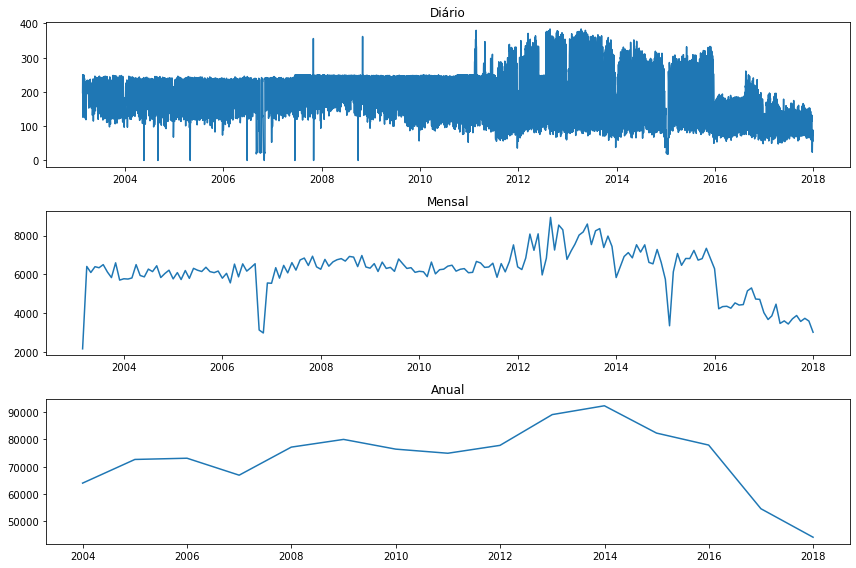

In [6]:
texto = df['headline_text']
texto.index = df['publish_date']

diario_total = texto.resample('D').count()
mensal_total = texto.resample('M').count()
anual_total = texto.resample('A').count()

fig, ax = plt.subplots(3, figsize=(12, 8))
ax[0].plot(diario_total);
ax[0].set_title('Diário');
ax[1].plot(mensal_total);
ax[1].set_title('Mensal');
ax[2].plot(anual_total);
ax[2].set_title('Anual');
plt.tight_layout()
plt.show()

In [7]:
def extrai_palavras(texto, num_palavras):
    
    bow = CountVectorizer(stop_words='english')

    texto_vet = bow.fit_transform(texto.values)
    vet_total = np.sum(texto_vet, axis=0)
    
    p_ind = np.flip(np.argsort(vet_total)[0,:], 1)
    p_val = np.flip(np.sort(vet_total)[0,:], 1)
    p_vet = np.zeros((num_palavras, texto_vet.shape[1]))
    for i in range(num_palavras):
        p_vet[i, p_ind[0, i]] = 1
    
    p = [pv[0].encode('ascii').decode('utf-8') for pv in bow.inverse_transform(p_vet)]

    return (p, p_val[0,:num_palavras].tolist()[0])

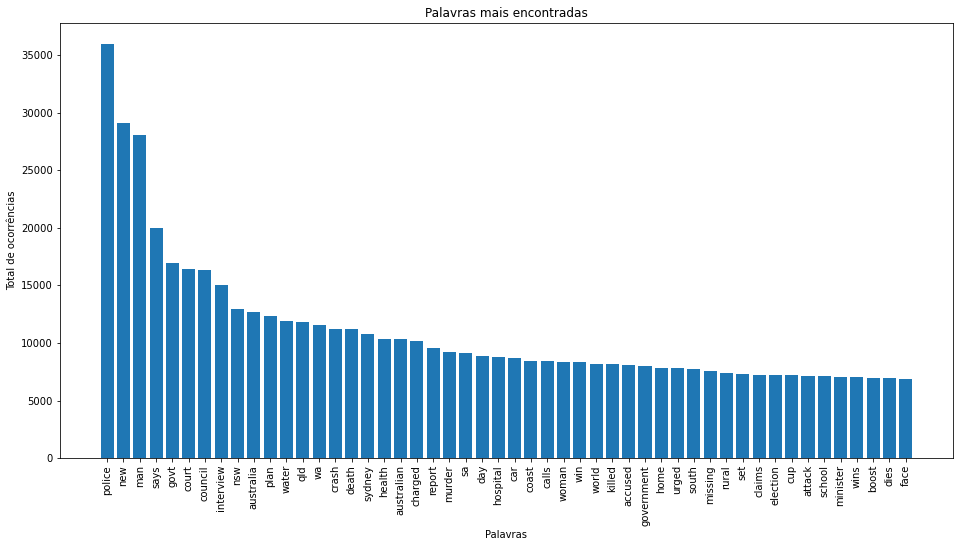

In [8]:
words, word_values = extrai_palavras(df['headline_text'], 50)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Palavras mais encontradas');
ax.set_xlabel('Palavras');
ax.set_ylabel('Total de ocorrências');
plt.show()

In [9]:
import textblob
texto_com_tags = [textblob.TextBlob(df['headline_text'][i]).pos_tags for i in range(df['headline_text'].shape[0])]

In [10]:
tags_df = pd.DataFrame({'tags':texto_com_tags})
tags_df.head()

,tags
0,"[(aba, JJ), (decides, NNS), (against, IN), (co..."
1,"[(act, NN), (fire, NN), (witnesses, NNS), (mus..."
2,"[(a, DT), (g, NN), (calls, VBZ), (for, IN), (i..."
3,"[(air, NN), (nz, JJ), (staff, NN), (in, IN), (..."
4,"[(air, NN), (nz, NNS), (strike, NN), (to, TO),..."


In [11]:
p_total = [] 
pos_total = {}

for texto in tags_df[u'tags']:
    p_total.append(len(texto))
    for tag in texto:
        if tag[1] in pos_total:
            pos_total[tag[1]] += 1
        else:
            pos_total[tag[1]] = 1
            
print('Número total de palavras: ', np.sum(p_total))
print('Número médio de palavras por notícia: ', np.mean(p_total))

Número total de palavras:  7079566
Número médio de palavras por notícia:  6.414608444787947


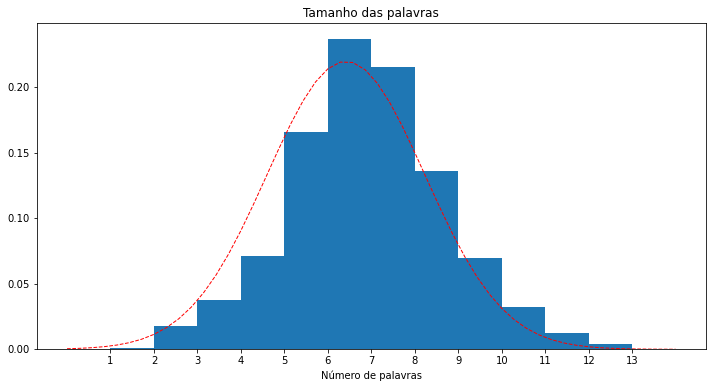

In [12]:
import scipy
y = scipy.stats.norm.pdf(np.linspace(0,14,50), np.mean(p_total), np.std(p_total))

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(p_total, bins=range(1,14), density=True);
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1);
ax.set_title('Tamanho das palavras');
ax.set_xticks(range(1,14));
ax.set_xlabel('Número de palavras');
plt.show()

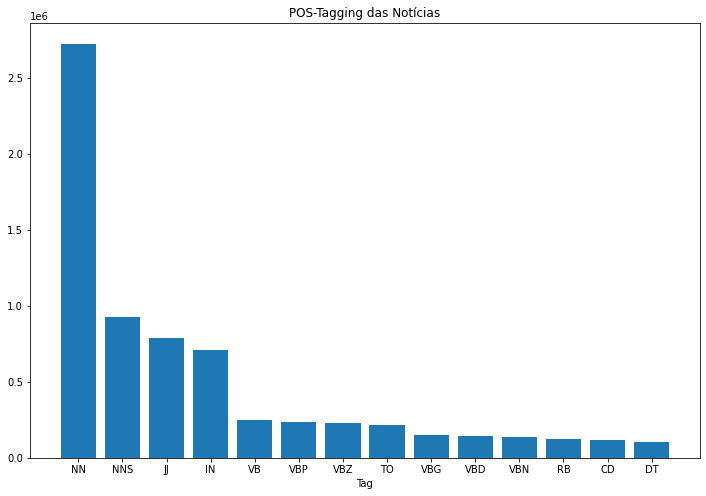

In [13]:
pos_sorted = sorted(pos_total, key=pos_total.__getitem__, reverse=True)
pos_total_sorted = sorted(pos_total.values(), reverse=True)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(np.arange(0, 14, 1.0), pos_total_sorted[0:14]);
ax.set_xticks(np.arange(0, 14, 1.0));
ax.set_xticklabels(pos_sorted[0:14]);

ax.set_title('POS-Tagging das Notícias');
ax.set_xlabel('Tag');

In [14]:
from collections import Counter

def extrai_chaves(vet):
    chaves = vet.argmax(axis=1).tolist()
    return chaves

def extrai_categorias(chaves):
    pares = Counter(chaves).items()
    categorias = [pair[0] for pair in pares]
    total = [pair[1] for pair in pares]
    return (categorias, total)

def extrai_palavras_lda(num_palavras, chaves, vet, bow):
    indices = []
    for topic in range(8):
        temp = 0
        for i in range(len(chaves)):
            if chaves[i] == topic:
                temp += vet[i]
        temp = temp.toarray()
        top_n_word_indices = np.flip(np.argsort(temp)[0][-num_palavras:],0)
        indices.append(top_n_word_indices)   
    top_words = []
    for topic in indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,vet.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = bow.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [15]:
from sklearn.decomposition import LatentDirichletAllocation

# Para fazer a extração com otodo o conjunto de textos
# bow = CountVectorizer(stop_words='english')
# texto_vet = bow.fit_transform(texto.values)

bow = CountVectorizer(stop_words='english', max_features=50000)
texto_resample = df['headline_text'].sample(n=10000, random_state=0).values
texto_resample_vet = bow.fit_transform(texto_resample)

lda_model = LatentDirichletAllocation(n_components=8, learning_method='online', random_state=0, verbose=0)
lda_vet = lda_model.fit_transform(texto_resample_vet) # se for usar todo o corpus, substituir texto_resample_vet >> texto_vet
lda_keys = extrai_chaves(lda_vet)
lda_categories, lda_counts = extrai_categorias(lda_keys)

In [16]:
palavras_lda = extrai_palavras_lda(10, lda_keys, texto_resample_vet, bow)

for i in range(len(palavras_lda)):
    print("Tópico {}: ".format(i+1), palavras_lda[i])

Tópico 1:  police child calls day court says abuse dead change market
Tópico 2:  council court coast murder gold government face says national police
Tópico 3:  man charged police nsw sydney home road hit crash guilty
Tópico 4:  says wa death sa abc australian report open sex final
Tópico 5:  new qld election ban country future trial end industry hour
Tópico 6:  interview australia world cup china south accused pm hill work
Tópico 7:  police health govt hospital plan boost car minister school house
Tópico 8:  new water killed high attack public farmers funding police urged


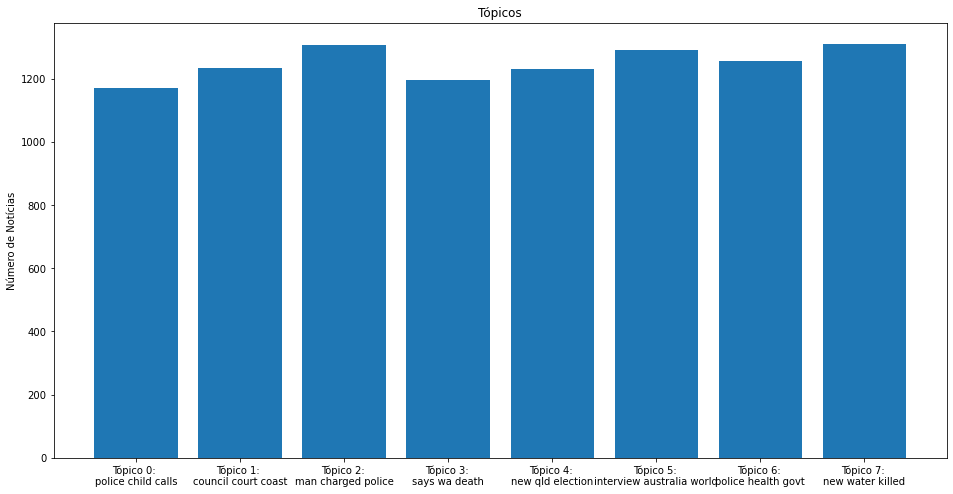

In [17]:
palavras_lda = extrai_palavras_lda(3, lda_keys, texto_resample_vet, bow)
labels = ['Tópico {}: \n'.format(i) + palavras_lda[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('Tópicos');
ax.set_ylabel('Número de Notícias');

In [18]:
from sklearn.manifold import TSNE
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_vet)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.034s...
[t-SNE] Computed neighbors for 10000 samples in 2.903s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.840584
[t-SNE] KL divergence after 2000 iterations: 1.221252


In [19]:
def extrai_centroides_lda(chaves, vet):
    cent_vet = []
    for t in range(8): # 8 tópicos
        articles_in_that_topic = []
        for i in range(len(chaves)):
            if chaves[i] == t:
                articles_in_that_topic.append(vet[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        cent_vet.append(mean_article_in_that_topic)
    return cent_vet

In [20]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:8]

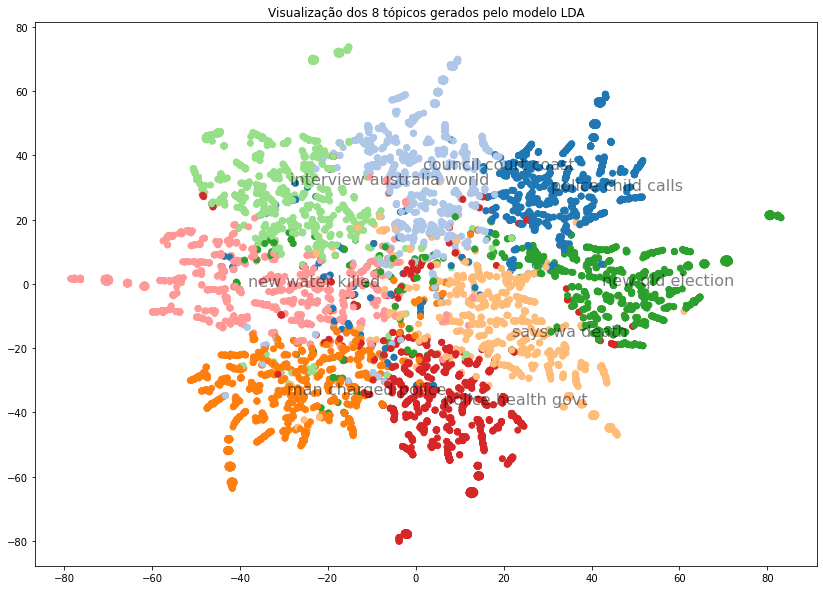

In [21]:
palavras_lda = extrai_palavras_lda(3, lda_keys, texto_resample_vet, bow)
centroides_lda = extrai_centroides_lda(lda_keys, tsne_lda_vectors)

fig, ax = plt.subplots(figsize=(14, 10))
ax.set_title('Visualização dos 8 tópicos gerados pelo modelo LDA');
plt.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(8):
    plt.text(x=centroides_lda[t][0], y=centroides_lda[t][1], s=palavras_lda[t], 
             fontdict=dict(color='black', alpha=0.5, size=16))